# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
import scipy as sc
from scipy import signal
import cv2
import PIL
import optuna

# Raw Dataset

In [2]:
df = pd.read_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\50_Users_Acceleromter_Data.csv")
df

,X,Y,Z,Label
0,0.340509,8.308413,4.140585,0
1,0.381370,8.390134,4.249548,0
2,0.272407,8.471856,4.018002,0
3,0.149824,8.430995,4.290409,0
4,0.272407,8.430995,4.481094,0
...,...,...,...,...
749995,-7.201759,-4.750096,-1.532289,49
749996,-7.354988,-5.209783,-1.991976,49
749997,-7.201759,-5.056554,-2.145205,49
749998,-7.354988,-5.363012,-2.298433,49


## Distributing User Data to Array

In [3]:
length = 15000

In [4]:
import time
start_time = time.time()
N_Users=5
k=0
X=[0 for p in range(N_Users)] # Final Array
for i in range(0,length*N_Users,length):
    temp=[]
    for j in range(length):
        x_y_z = [df.iloc[i+j,0],df.iloc[i+j,1],df.iloc[i+j,2]]
        temp.append(x_y_z)
    X[k]=temp
    k+=1 #incrementing [Final Array] indices
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.5101745128631592 seconds ---


In [5]:
t=np.array(X)
t.shape

(5, 15000, 3)

## Algo for creating windows

In [6]:
# Main Algo for Creating Windows .....#1

def create(df,wind_size,hop_size,m_index):
  #l=((len(df.x)-wind_size)/hop_size)+1
  rows, cols = (wind_size, 3) 
#  a = [[0 for i in range(cols)] for j in range(rows)] 
  array= [0 for i in range(int((length-wind_size)/hop_size)+1)]
  k = 0
  for i in range(0,(length-wind_size+1),hop_size):
      a=create1(df,i,wind_size,m_index)
       #array.append(a)
      array[k] = a
      k+=1
  #return pd.DataFrame(array)
  return array


In [7]:
# Main Algo for Creating Windows .....#2

def create1(df,x,w,m_index):
     rows = w 
     cols = 3
     arr = [[0 for i in range(cols)] for j in range(rows)] 
     for i in range(0,w,1):
        arr[i][0]=df[x+i][0]
        arr[i][1]=df[x+i][1]
        arr[i][2]=df[x+i][2]
     arr = np.array(arr)
     f1,t1,x = signal.stft(arr[:,0],5,nperseg=10)
     f2,t2,y = signal.stft(arr[:,1],5,nperseg=10)
     f3,t3,z = signal.stft(arr[:,2],5,nperseg=10)
     temp_a = np.concatenate((abs(np.array(x)),abs(np.array(y)),abs(np.array(z))),axis=0)
     return temp_a

## Final Array for training

In [8]:
import time
start_time = time.time()
X_final = [0 for i in range( N_Users)]
for m_index in range(N_Users):
  X_final[m_index]=create(X[m_index],225,10,m_index)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.839966773986816 seconds ---


In [9]:
t=np.array(X_final[0])
t.shape             # The shape gives(number of windows,shape of TF plot image)

(1478, 18, 46)

In [10]:
X_input=[]
for i in range(N_Users):
  temp = X_final[i]
  X_input += temp
X_input = np.array(X_input)

## A typical TF plot of one window

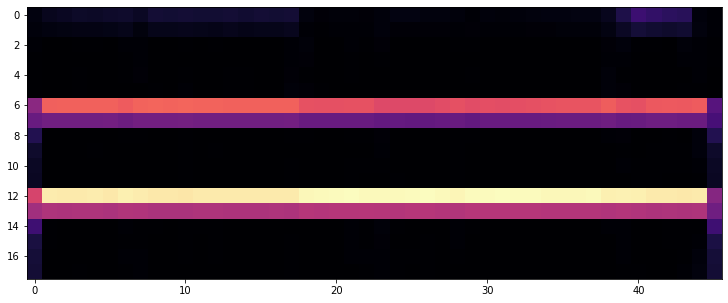

In [12]:
plt.imshow(X_input[5000],cmap='magma')
fig = plt.gcf()
fig.set_size_inches(15,5)

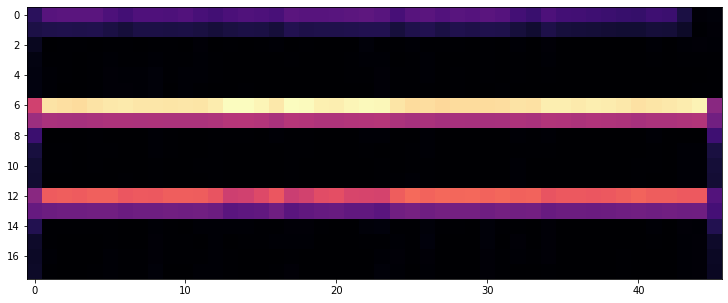

In [13]:
plt.imshow(X_input[1477],cmap='magma')
fig = plt.gcf()
fig.set_size_inches(15,5)
#plt.savefig(r'E:\Academic\Project\User Identity from Time-Frequency Analysis\outfile.jpg')

## Creating Labels

In [14]:
y = [0 for i in range(X_input.shape[0])]
for i in range(X_input.shape[0]):
  y[i]=int(i*N_Users/X_input.shape[0])
y = np.array(y)

## Splitting into training and testing

In [15]:
import sklearn
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X_input,y,test_size = 0.2,shuffle=True)

# The MODEL

In [16]:
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout

Using TensorFlow backend.


## Model Architecture

In [19]:
clf = tensorflow.keras.Sequential()

In [22]:
clf.add(keras.layers.Conv2D(64, (3,3), activation= 'relu', input_shape = (X_input.shape[1],X_input.shape[2],1), padding='same'))
clf.add(keras.layers.Conv2D(32, (3,3), activation= 'relu',padding='same'))
clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
clf.add(keras.layers.Dropout(rate= 0.5))

clf.add(keras.layers.Conv2D(64, (3,3), activation= 'relu',padding='same'))
clf.add(keras.layers.Conv2D(32, (3,3), activation= 'relu',padding='same'))
clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
clf.add(keras.layers.Dropout(rate= 0.5))


clf.add(keras.layers.Flatten())
          
clf.add(keras.layers.Dense(128,activation='relu'))
clf.add(keras.layers.Dense(32,activation = 'relu'))
clf.add(keras.layers.Dense(N_Users,activation='softmax'))

In [23]:
clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 46, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 46, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 46, 32)        0

In [24]:
clf.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [46]:
#Reshaping the input
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

## Trying the Model out

In [26]:
history = clf.fit(X_train,y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test))

Train on 11824 samples, validate on 2956 samples
Epoch 1/50
11824/11824 [==============================] - 51s 4ms/sample - loss: 1.9016 - accuracy: 0.2977 - val_loss: 1.7337 - val_accuracy: 0.3823
Epoch 2/50
11824/11824 [==============================] - 52s 4ms/sample - loss: 1.5934 - accuracy: 0.4263 - val_loss: 1.4586 - val_accuracy: 0.4702
Epoch 3/50
11824/11824 [==============================] - 51s 4ms/sample - loss: 1.3232 - accuracy: 0.5316 - val_loss: 1.2239 - val_accuracy: 0.5670
Epoch 4/50
11824/11824 [==============================] - 49s 4ms/sample - loss: 1.1041 - accuracy: 0.6030 - val_loss: 1.0056 - val_accuracy: 0.6485
Epoch 5/50
11824/11824 [==============================] - 49s 4ms/sample - loss: 0.9128 - accuracy: 0.6774 - val_loss: 0.8929 - val_accuracy: 0.6783
Epoch 6/50
11824/11824 [==============================] - 49s 4ms/sample - loss: 0.7572 - accuracy: 0.7272 - val_loss: 0.7913 - val_accuracy: 0.7135
Epoch 7/50
11824/11824 [==============================] -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


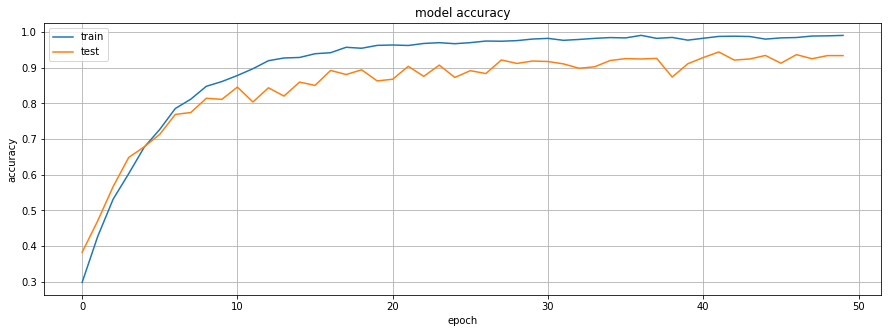

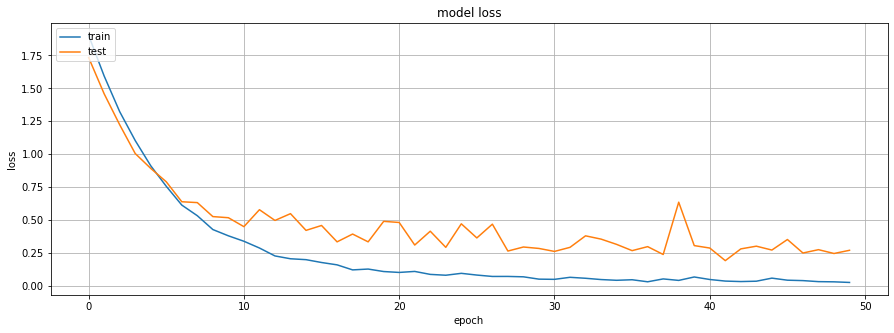

In [27]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.grid()
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.grid()
plt.show()

In [75]:
from sklearn import metrics
pred_y = clf.predict(X_test)

In [76]:
y_pred=[]
for i in range(y_test.shape[0]):
     temp=np.array(pred_y[i])    
     maximum = np.where(temp==max(temp))
     y_pred.append(maximum[0]) 

In [77]:
recall = metrics.recall_score(y_test, y_pred, labels=[1,2], average='micro')
precision = metrics.precision_score(y_test, y_pred, labels=[1,2], average='micro')
f1 = metrics.f1_score(y_test, y_pred, labels=[1,2], average='micro')
print('Recall: %.4f' % recall,'Precision: %.4f' % precision,'F-Measure: %.4f' % f1)

Recall: 0.6561 Precision: 0.5708 F-Measure: 0.6105


## Keeping Records

In [78]:
metrics_df=pd.DataFrame(history.history)
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,3.177004,0.177368,2.585541,0.296414
1,2.151085,0.395754,1.819311,0.473207
2,1.596172,0.530193,1.561804,0.535521
3,1.280952,0.613024,1.668845,0.522598
4,1.064058,0.673106,1.718104,0.534709


In [79]:
loss = pd.DataFrame(metrics_df.iloc[:,0].values,columns=[str(N_Users)])
accuracy = pd.DataFrame(metrics_df.iloc[:,1].values,columns=[str(N_Users)])
val_loss = pd.DataFrame(metrics_df.iloc[:,2].values,columns=[str(N_Users)])
val_accuracy = pd.DataFrame(metrics_df.iloc[:,3].values,columns=[str(N_Users)])

In [80]:
cf_matrix=metrics.confusion_matrix(y_test,y_pred)
cf_matrix

array([[271,   0,   5, ...,   0,   0,   0],
       [  1, 119,  15, ...,   0,   0,   0],
       [  0,   0, 276, ...,   0,   0,   0],
       ...,
       [  2,   1,   7, ...,  96,   2,   0],
       [  6,   1,   0, ...,   0, 106,   0],
       [  0,   0,   0, ...,   0,   0, 284]], dtype=int64)

In [81]:
cf_mat = pd.DataFrame(cf_matrix)
cf_mat
cf_mat.to_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\Project Report\Results\Confusion Matrix\cf_mat_50.csv")

In [82]:
loss.to_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\Project Report\Results\Loss\loss_50.csv")
accuracy.to_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\Project Report\Results\Accuracy\accuracy_50.csv")
val_loss.to_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\Project Report\Results\Val_Loss\val_loss_50.csv")
val_accuracy.to_csv(r"E:\Academic\Project\User Identity from Time-Frequency Analysis\Project Report\Results\Val_Accuracy\val_accuracy_50.csv")

# Hyperparameter Tuning

In [54]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    #clear_session()
    
    filters_= trial.suggest_categorical("filters", [32, 64])
    kernel_size_= trial.suggest_categorical("kernel_size", [3, 5])
    strides_= trial.suggest_categorical("strides", [1, 2])
    activation_= trial.suggest_categorical("activation", ["relu", "linear"])
    padding_ = trial.suggest_categorical("padding", ["same"])
    
    clf = keras.Sequential()
                                         
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_, input_shape = (X_input.shape[1],X_input.shape[2],1)))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.Conv2D(filters=filters_, kernel_size = kernel_size_ ,strides = strides_ ,activation = activation_ ,padding = padding_))
    clf.add(keras.layers.MaxPool2D(pool_size= (1,1)))
    clf.add(keras.layers.Dropout(rate= 0.5))

    clf.add(keras.layers.Flatten())

    clf.add(keras.layers.Dense(64,activation='relu'))
    clf.add(keras.layers.Dense(32,activation = 'relu'))
    clf.add(keras.layers.Dense(N_Users,activation='softmax'))

    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    clf.compile(loss="sparse_categorical_crossentropy", optimizer = keras.optimizers.RMSprop(lr=lr), metrics=["accuracy"])

    clf.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        shuffle=True,
        batch_size=128,
        epochs=1,
    )

    # Evaluate the model accuracy on the validation set.
    score = clf.evaluate(X_test,y_test,verbose=0)
    return score[1]


In [55]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-14 17:21:05,150] A new study created in memory with name: no-name-bbb787f3-0252-47d8-8ed8-10c7b30370aa


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 44s - loss: 1.6051 - accuracy: 0.171 - ETA: 15s - loss: 1273.8587 - accuracy: 0.18 - ETA: 9s - loss: 764.9704 - accuracy: 0.1922 - ETA: 6s - loss: 546.8658 - accuracy: 0.18 - ETA: 5s - loss: 425.6909 - accuracy: 0.21 - ETA: 4s - loss: 348.5768 - accuracy: 0.22 - ETA: 3s - loss: 295.1915 - accuracy: 0.23 - ETA: 3s - loss: 256.0265 - accuracy: 0.24 - ETA: 2s - loss: 226.0769 - accuracy: 0.25 - ETA: 2s - loss: 202.4323 - accuracy: 0.25 - ETA: 2s - loss: 183.2953 - accuracy: 0.26 - ETA: 1s - loss: 167.4868 - accuracy: 0.26 - ETA: 1s - loss: 154.2082 - accuracy: 0.26 - ETA: 1s - loss: 142.8939 - accuracy: 0.26 - ETA: 1s - loss: 133.1490 - accuracy: 0.26 - ETA: 1s - loss: 124.6545 - accuracy: 0.27 - ETA: 0s - loss: 117.1923 - accuracy: 0.27 - ETA: 0s - loss: 110.5791 - accuracy: 0.27 - ETA: 0s - loss: 104.6781 - accuracy: 0.28 - ETA: 0s - loss: 99.3800 - accuracy: 0.2905 - ETA: 0s - loss: 94.610

[I 2021-01-14 17:21:08,555] Trial 0 finished with value: 0.3207036554813385 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'padding': 'same', 'lr': 0.021291954844568486}. Best is trial 0 with value: 0.3207036554813385.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 51s - loss: 2.6331 - accuracy: 0.250 - ETA: 17s - loss: 2.6595 - accuracy: 0.216 - ETA: 8s - loss: 2.6438 - accuracy: 0.201 - ETA: 5s - loss: 2.6397 - accuracy: 0.19 - ETA: 3s - loss: 2.6102 - accuracy: 0.19 - ETA: 3s - loss: 2.5599 - accuracy: 0.19 - ETA: 2s - loss: 2.5270 - accuracy: 0.19 - ETA: 2s - loss: 2.4935 - accuracy: 0.20 - ETA: 1s - loss: 2.4692 - accuracy: 0.20 - ETA: 1s - loss: 2.4448 - accuracy: 0.20 - ETA: 1s - loss: 2.4105 - accuracy: 0.20 - ETA: 0s - loss: 2.3808 - accuracy: 0.20 - ETA: 0s - loss: 2.3533 - accuracy: 0.20 - ETA: 0s - loss: 2.3264 - accuracy: 0.20 - ETA: 0s - loss: 2.3137 - accuracy: 0.20 - ETA: 0s - loss: 2.2876 - accuracy: 0.21 - ETA: 0s - loss: 2.2750 - accuracy: 0.21 - ETA: 0s - loss: 2.2643 - accuracy: 0.21 - 2s 420us/sample - loss: 2.2636 - accuracy: 0.2136 - val_loss: 1.6425 - val_accuracy: 0.1894


[I 2021-01-14 17:21:11,368] Trial 1 finished with value: 0.18944519758224487 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'linear', 'padding': 'same', 'lr': 2.2954444638088986e-05}. Best is trial 0 with value: 0.3207036554813385.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 57s - loss: 1.6087 - accuracy: 0.179 - ETA: 35s - loss: 10055.2419 - accuracy: 0.191 - ETA: 27s - loss: 6706.6017 - accuracy: 0.184 - ETA: 23s - loss: 5030.3619 - accuracy: 0.19 - ETA: 21s - loss: 4024.6114 - accuracy: 0.20 - ETA: 19s - loss: 3354.1092 - accuracy: 0.21 - ETA: 17s - loss: 2875.1827 - accuracy: 0.20 - ETA: 16s - loss: 2515.9877 - accuracy: 0.20 - ETA: 16s - loss: 2236.6119 - accuracy: 0.20 - ETA: 15s - loss: 2013.1134 - accuracy: 0.20 - ETA: 14s - loss: 1830.2497 - accuracy: 0.20 - ETA: 13s - loss: 1677.8631 - accuracy: 0.20 - ETA: 13s - loss: 1548.9206 - accuracy: 0.20 - ETA: 12s - loss: 1438.3986 - accuracy: 0.20 - ETA: 11s - loss: 1342.6123 - accuracy: 0.20 - ETA: 11s - loss: 1258.7990 - accuracy: 0.20 - ETA: 11s - loss: 1184.8584 - accuracy: 0.20 - ETA: 10s - loss: 1119.1224 - accuracy: 0.20 - ETA: 10s - loss: 1060.3062 - accuracy: 0.20 - ETA: 9s - loss: 1007.3715 - accu

[I 2021-01-14 17:21:29,405] Trial 2 finished with value: 0.1752368062734604 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.02188309568993333}. Best is trial 0 with value: 0.3207036554813385.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:59 - loss: 1.8259 - accuracy: 0.18 - ETA: 1:31 - loss: 9754.8544 - accuracy: 0.207 - ETA: 1:20 - loss: 59118140.5696 - accuracy: 0.169 - ETA: 1:15 - loss: 59101354.4272 - accuracy: 0.175 - ETA: 1:11 - loss: 77303713.9417 - accuracy: 0.184 - ETA: 1:07 - loss: 1544680198.9515 - accuracy: 0.181 - ETA: 1:05 - loss: 1333495316.8155 - accuracy: 0.183 - ETA: 1:02 - loss: 1203575970.2136 - accuracy: 0.186 - ETA: 1:00 - loss: 1072458141.9676 - accuracy: 0.185 - ETA: 58s - loss: 971108073.3709 - accuracy: 0.1852  - ETA: 56s - loss: 885372734.1553 - accuracy: 0.191 - ETA: 54s - loss: 812459014.6424 - accuracy: 0.186 - ETA: 52s - loss: 750131806.1507 - accuracy: 0.185 - ETA: 50s - loss: 696551032.8682 - accuracy: 0.188 - ETA: 49s - loss: 650114311.1064 - accuracy: 0.187 - ETA: 47s - loss: 609482166.7628 - accuracy: 0.189 - ETA: 45s - loss: 573630274.6954 - accuracy: 0.189 - ETA: 44s - loss: 54176192

[I 2021-01-14 17:22:53,320] Trial 3 finished with value: 0.1752368062734604 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'linear', 'padding': 'same', 'lr': 0.022424596647454775}. Best is trial 0 with value: 0.3207036554813385.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 44s - loss: 1.6019 - accuracy: 0.218 - ETA: 15s - loss: 3.2611 - accuracy: 0.205 - ETA: 9s - loss: 2.6018 - accuracy: 0.200 - ETA: 6s - loss: 2.3157 - accuracy: 0.20 - ETA: 5s - loss: 2.1493 - accuracy: 0.21 - ETA: 4s - loss: 2.0430 - accuracy: 0.23 - ETA: 3s - loss: 1.9667 - accuracy: 0.24 - ETA: 3s - loss: 1.9025 - accuracy: 0.25 - ETA: 2s - loss: 1.8496 - accuracy: 0.27 - ETA: 2s - loss: 1.8199 - accuracy: 0.27 - ETA: 2s - loss: 1.7840 - accuracy: 0.28 - ETA: 1s - loss: 1.7492 - accuracy: 0.28 - ETA: 1s - loss: 1.7172 - accuracy: 0.29 - ETA: 1s - loss: 1.6857 - accuracy: 0.30 - ETA: 1s - loss: 1.6738 - accuracy: 0.30 - ETA: 1s - loss: 1.6504 - accuracy: 0.31 - ETA: 0s - loss: 1.6303 - accuracy: 0.32 - ETA: 0s - loss: 1.6097 - accuracy: 0.32 - ETA: 0s - loss: 1.5944 - accuracy: 0.33 - ETA: 0s - loss: 1.5829 - accuracy: 0.33 - ETA: 0s - loss: 1.5689 - accuracy: 0.34 - ETA: 0s - loss: 1.56

[I 2021-01-14 17:22:56,674] Trial 4 finished with value: 0.3626522421836853 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'activation': 'relu', 'padding': 'same', 'lr': 0.003789385568103966}. Best is trial 4 with value: 0.3626522421836853.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 57s - loss: 1.6468 - accuracy: 0.171 - ETA: 35s - loss: 4.0298 - accuracy: 0.175 - ETA: 27s - loss: 3.6401 - accuracy: 0.169 - ETA: 23s - loss: 3.1331 - accuracy: 0.173 - ETA: 20s - loss: 2.8262 - accuracy: 0.201 - ETA: 19s - loss: 2.6211 - accuracy: 0.213 - ETA: 17s - loss: 2.4723 - accuracy: 0.226 - ETA: 16s - loss: 2.3551 - accuracy: 0.241 - ETA: 15s - loss: 2.2926 - accuracy: 0.237 - ETA: 14s - loss: 2.2171 - accuracy: 0.250 - ETA: 14s - loss: 2.1564 - accuracy: 0.251 - ETA: 13s - loss: 2.1072 - accuracy: 0.249 - ETA: 13s - loss: 2.0617 - accuracy: 0.253 - ETA: 12s - loss: 2.0170 - accuracy: 0.264 - ETA: 11s - loss: 1.9761 - accuracy: 0.273 - ETA: 11s - loss: 1.9408 - accuracy: 0.276 - ETA: 10s - loss: 1.9086 - accuracy: 0.282 - ETA: 10s - loss: 1.8762 - accuracy: 0.293 - ETA: 10s - loss: 1.8477 - accuracy: 0.299 - ETA: 9s - loss: 1.8239 - accuracy: 0.305 - ETA: 9s - loss: 1.7973 - acc

[I 2021-01-14 17:23:14,974] Trial 5 finished with value: 0.4803788959980011 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.0022646939695784374}. Best is trial 5 with value: 0.4803788959980011.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:49 - loss: 1.7276 - accuracy: 0.17 - ETA: 1:26 - loss: 1.9482 - accuracy: 0.21 - ETA: 1:18 - loss: 1.8020 - accuracy: 0.23 - ETA: 1:13 - loss: 1.7258 - accuracy: 0.28 - ETA: 1:09 - loss: 1.6935 - accuracy: 0.30 - ETA: 1:06 - loss: 1.6350 - accuracy: 0.31 - ETA: 1:03 - loss: 1.5857 - accuracy: 0.33 - ETA: 1:01 - loss: 1.5563 - accuracy: 0.35 - ETA: 59s - loss: 1.5441 - accuracy: 0.3516 - ETA: 57s - loss: 1.5382 - accuracy: 0.344 - ETA: 55s - loss: 1.5200 - accuracy: 0.350 - ETA: 53s - loss: 1.4990 - accuracy: 0.359 - ETA: 51s - loss: 1.4799 - accuracy: 0.364 - ETA: 50s - loss: 1.4635 - accuracy: 0.367 - ETA: 48s - loss: 1.4551 - accuracy: 0.372 - ETA: 46s - loss: 1.4440 - accuracy: 0.373 - ETA: 45s - loss: 1.4403 - accuracy: 0.371 - ETA: 43s - loss: 1.4406 - accuracy: 0.370 - ETA: 41s - loss: 1.4353 - accuracy: 0.370 - ETA: 40s - loss: 1.4254 - accuracy: 0.372 - ETA: 38s - loss: 1.4188 - 

[I 2021-01-14 17:24:38,638] Trial 6 finished with value: 0.4553450644016266 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'activation': 'linear', 'padding': 'same', 'lr': 0.00012035105135207528}. Best is trial 5 with value: 0.4803788959980011.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 42s - loss: 1.7641 - accuracy: 0.257 - ETA: 14s - loss: 1.6913 - accuracy: 0.289 - ETA: 8s - loss: 1.6668 - accuracy: 0.273 - ETA: 5s - loss: 1.6159 - accuracy: 0.27 - ETA: 3s - loss: 1.6172 - accuracy: 0.28 - ETA: 2s - loss: 1.6054 - accuracy: 0.28 - ETA: 2s - loss: 1.5896 - accuracy: 0.28 - ETA: 1s - loss: 1.5682 - accuracy: 0.29 - ETA: 1s - loss: 1.5584 - accuracy: 0.30 - ETA: 1s - loss: 1.5490 - accuracy: 0.30 - ETA: 1s - loss: 1.5416 - accuracy: 0.31 - ETA: 0s - loss: 1.5192 - accuracy: 0.32 - ETA: 0s - loss: 1.5025 - accuracy: 0.33 - ETA: 0s - loss: 1.4928 - accuracy: 0.33 - ETA: 0s - loss: 1.4845 - accuracy: 0.34 - ETA: 0s - loss: 1.4763 - accuracy: 0.34 - ETA: 0s - loss: 1.4659 - accuracy: 0.34 - 2s 383us/sample - loss: 1.4641 - accuracy: 0.3491 - val_loss: 1.2629 - val_accuracy: 0.4520


[I 2021-01-14 17:24:41,232] Trial 7 finished with value: 0.45196211338043213 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'activation': 'linear', 'padding': 'same', 'lr': 0.0016644963848726152}. Best is trial 5 with value: 0.4803788959980011.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:30 - loss: 1.6276 - accuracy: 0.25 - ETA: 1:02 - loss: 2.6796 - accuracy: 0.23 - ETA: 52s - loss: 2.2919 - accuracy: 0.2917 - ETA: 47s - loss: 2.0778 - accuracy: 0.312 - ETA: 43s - loss: 2.0505 - accuracy: 0.318 - ETA: 41s - loss: 1.9684 - accuracy: 0.324 - ETA: 39s - loss: 1.9061 - accuracy: 0.313 - ETA: 37s - loss: 1.8493 - accuracy: 0.322 - ETA: 35s - loss: 1.7989 - accuracy: 0.329 - ETA: 34s - loss: 1.7586 - accuracy: 0.335 - ETA: 33s - loss: 1.7287 - accuracy: 0.341 - ETA: 31s - loss: 1.6948 - accuracy: 0.350 - ETA: 30s - loss: 1.6582 - accuracy: 0.358 - ETA: 29s - loss: 1.6577 - accuracy: 0.361 - ETA: 28s - loss: 1.6424 - accuracy: 0.359 - ETA: 27s - loss: 1.6249 - accuracy: 0.360 - ETA: 26s - loss: 1.6058 - accuracy: 0.367 - ETA: 25s - loss: 1.5886 - accuracy: 0.368 - ETA: 24s - loss: 1.5775 - accuracy: 0.368 - ETA: 23s - loss: 1.5656 - accuracy: 0.371 - ETA: 22s - loss: 1.5540 - 

[I 2021-01-14 17:25:28,379] Trial 8 finished with value: 0.4905277490615845 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.0008465448849043298}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:04 - loss: 2.5421 - accuracy: 0.18 - ETA: 39s - loss: 2.2240 - accuracy: 0.1797 - ETA: 30s - loss: 2.0525 - accuracy: 0.192 - ETA: 25s - loss: 1.9400 - accuracy: 0.199 - ETA: 22s - loss: 1.8822 - accuracy: 0.201 - ETA: 20s - loss: 1.8393 - accuracy: 0.209 - ETA: 19s - loss: 1.8094 - accuracy: 0.217 - ETA: 17s - loss: 1.7719 - accuracy: 0.230 - ETA: 16s - loss: 1.7478 - accuracy: 0.231 - ETA: 15s - loss: 1.7266 - accuracy: 0.239 - ETA: 14s - loss: 1.7036 - accuracy: 0.252 - ETA: 14s - loss: 1.6869 - accuracy: 0.256 - ETA: 13s - loss: 1.6645 - accuracy: 0.269 - ETA: 12s - loss: 1.6444 - accuracy: 0.281 - ETA: 12s - loss: 1.6249 - accuracy: 0.290 - ETA: 11s - loss: 1.6109 - accuracy: 0.294 - ETA: 11s - loss: 1.5993 - accuracy: 0.300 - ETA: 10s - loss: 1.5855 - accuracy: 0.308 - ETA: 10s - loss: 1.5733 - accuracy: 0.313 - ETA: 9s - loss: 1.5644 - accuracy: 0.318 - ETA: 9s - loss: 1.5538 - ac

[I 2021-01-14 17:25:46,275] Trial 9 finished with value: 0.41136670112609863 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'linear', 'padding': 'same', 'lr': 5.282551682119505e-05}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:19 - loss: 1.6220 - accuracy: 0.22 - ETA: 57s - loss: 1.6785 - accuracy: 0.2344 - ETA: 49s - loss: 1.9146 - accuracy: 0.268 - ETA: 45s - loss: 1.8199 - accuracy: 0.306 - ETA: 42s - loss: 1.7691 - accuracy: 0.304 - ETA: 39s - loss: 1.7259 - accuracy: 0.319 - ETA: 37s - loss: 1.6898 - accuracy: 0.334 - ETA: 36s - loss: 1.6648 - accuracy: 0.335 - ETA: 34s - loss: 1.6366 - accuracy: 0.349 - ETA: 33s - loss: 1.6176 - accuracy: 0.347 - ETA: 32s - loss: 1.6036 - accuracy: 0.357 - ETA: 31s - loss: 1.5804 - accuracy: 0.366 - ETA: 29s - loss: 1.5578 - accuracy: 0.378 - ETA: 28s - loss: 1.5389 - accuracy: 0.385 - ETA: 27s - loss: 1.5257 - accuracy: 0.384 - ETA: 26s - loss: 1.5181 - accuracy: 0.385 - ETA: 25s - loss: 1.5069 - accuracy: 0.390 - ETA: 24s - loss: 1.5007 - accuracy: 0.389 - ETA: 23s - loss: 1.4933 - accuracy: 0.389 - ETA: 23s - loss: 1.4870 - accuracy: 0.390 - ETA: 22s - loss: 1.4764 - 

[I 2021-01-14 17:26:32,552] Trial 10 finished with value: 0.4465493857860565 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.0003679367334452258}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:29 - loss: 1.6145 - accuracy: 0.20 - ETA: 1:02 - loss: 2.1046 - accuracy: 0.21 - ETA: 52s - loss: 1.9464 - accuracy: 0.2708 - ETA: 47s - loss: 1.8292 - accuracy: 0.318 - ETA: 43s - loss: 1.7757 - accuracy: 0.329 - ETA: 41s - loss: 1.7259 - accuracy: 0.339 - ETA: 38s - loss: 1.6852 - accuracy: 0.352 - ETA: 37s - loss: 1.6473 - accuracy: 0.359 - ETA: 35s - loss: 1.6168 - accuracy: 0.364 - ETA: 34s - loss: 1.5795 - accuracy: 0.375 - ETA: 32s - loss: 1.5563 - accuracy: 0.380 - ETA: 31s - loss: 1.5439 - accuracy: 0.386 - ETA: 30s - loss: 1.5300 - accuracy: 0.390 - ETA: 29s - loss: 1.5140 - accuracy: 0.392 - ETA: 28s - loss: 1.5020 - accuracy: 0.397 - ETA: 27s - loss: 1.4917 - accuracy: 0.398 - ETA: 26s - loss: 1.4830 - accuracy: 0.398 - ETA: 25s - loss: 1.4713 - accuracy: 0.400 - ETA: 24s - loss: 1.4652 - accuracy: 0.401 - ETA: 23s - loss: 1.4589 - accuracy: 0.399 - ETA: 22s - loss: 1.4564 - 

[I 2021-01-14 17:27:18,473] Trial 11 finished with value: 0.36874154210090637 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.0005728710465758094}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:19 - loss: 1.6932 - accuracy: 0.19 - ETA: 56s - loss: 29.8188 - accuracy: 0.19 - ETA: 49s - loss: 20.4134 - accuracy: 0.22 - ETA: 45s - loss: 15.7089 - accuracy: 0.21 - ETA: 42s - loss: 12.8707 - accuracy: 0.26 - ETA: 39s - loss: 11.2649 - accuracy: 0.25 - ETA: 38s - loss: 10.0412 - accuracy: 0.25 - ETA: 36s - loss: 8.9870 - accuracy: 0.2471 - ETA: 34s - loss: 8.1665 - accuracy: 0.263 - ETA: 33s - loss: 7.5095 - accuracy: 0.268 - ETA: 32s - loss: 6.9740 - accuracy: 0.262 - ETA: 31s - loss: 6.5255 - accuracy: 0.274 - ETA: 30s - loss: 6.1451 - accuracy: 0.283 - ETA: 28s - loss: 5.8120 - accuracy: 0.295 - ETA: 27s - loss: 5.5357 - accuracy: 0.287 - ETA: 26s - loss: 5.2867 - accuracy: 0.289 - ETA: 25s - loss: 5.0588 - accuracy: 0.294 - ETA: 24s - loss: 4.8588 - accuracy: 0.295 - ETA: 23s - loss: 4.6820 - accuracy: 0.297 - ETA: 22s - loss: 4.5172 - accuracy: 0.299 - ETA: 21s - loss: 4.3666 - 

[I 2021-01-14 17:28:04,503] Trial 12 finished with value: 0.2983761727809906 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.00457028528840714}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:27 - loss: 1.6287 - accuracy: 0.22 - ETA: 1:01 - loss: 1.7366 - accuracy: 0.25 - ETA: 51s - loss: 1.6902 - accuracy: 0.2682 - ETA: 46s - loss: 1.6481 - accuracy: 0.271 - ETA: 42s - loss: 1.6004 - accuracy: 0.315 - ETA: 40s - loss: 1.5588 - accuracy: 0.328 - ETA: 38s - loss: 1.5354 - accuracy: 0.330 - ETA: 36s - loss: 1.5460 - accuracy: 0.320 - ETA: 35s - loss: 1.5198 - accuracy: 0.335 - ETA: 33s - loss: 1.5048 - accuracy: 0.344 - ETA: 32s - loss: 1.4869 - accuracy: 0.353 - ETA: 31s - loss: 1.4764 - accuracy: 0.361 - ETA: 30s - loss: 1.4650 - accuracy: 0.362 - ETA: 28s - loss: 1.4534 - accuracy: 0.367 - ETA: 27s - loss: 1.4488 - accuracy: 0.368 - ETA: 26s - loss: 1.4412 - accuracy: 0.370 - ETA: 25s - loss: 1.4289 - accuracy: 0.374 - ETA: 25s - loss: 1.4209 - accuracy: 0.376 - ETA: 24s - loss: 1.4104 - accuracy: 0.382 - ETA: 23s - loss: 1.4028 - accuracy: 0.386 - ETA: 22s - loss: 1.3924 - 

[I 2021-01-14 17:28:53,134] Trial 13 finished with value: 0.4526387155056 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.00023728535901056352}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:05 - loss: 1.6144 - accuracy: 0.26 - ETA: 40s - loss: 21120964.8072 - accuracy: 0.25 - ETA: 31s - loss: 14082103.6840 - accuracy: 0.23 - ETA: 26s - loss: 10563791.0818 - accuracy: 0.21 - ETA: 23s - loss: 8451036.0237 - accuracy: 0.2141 - ETA: 21s - loss: 7042530.4284 - accuracy: 0.201 - ETA: 20s - loss: 6036454.9149 - accuracy: 0.206 - ETA: 18s - loss: 5281898.3339 - accuracy: 0.204 - ETA: 17s - loss: 4695020.9476 - accuracy: 0.200 - ETA: 16s - loss: 4225519.0315 - accuracy: 0.200 - ETA: 15s - loss: 3841381.1481 - accuracy: 0.200 - ETA: 15s - loss: 3521266.1973 - accuracy: 0.197 - ETA: 14s - loss: 3250399.7225 - accuracy: 0.194 - ETA: 13s - loss: 3018228.4426 - accuracy: 0.194 - ETA: 13s - loss: 2817013.3297 - accuracy: 0.195 - ETA: 12s - loss: 2640950.1142 - accuracy: 0.197 - ETA: 12s - loss: 2485600.2106 - accuracy: 0.198 - ETA: 11s - loss: 2347511.4030 - accuracy: 0.199 - ETA: 11s - l

[I 2021-01-14 17:29:12,903] Trial 14 finished with value: 0.21650879085063934 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.08925768831706396}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:27 - loss: 1.6541 - accuracy: 0.13 - ETA: 1:02 - loss: 4.4533 - accuracy: 0.16 - ETA: 53s - loss: 3.5284 - accuracy: 0.1641 - ETA: 49s - loss: 3.0474 - accuracy: 0.191 - ETA: 45s - loss: 2.7547 - accuracy: 0.209 - ETA: 43s - loss: 2.5358 - accuracy: 0.251 - ETA: 41s - loss: 2.4929 - accuracy: 0.279 - ETA: 39s - loss: 2.3728 - accuracy: 0.291 - ETA: 38s - loss: 2.2713 - accuracy: 0.309 - ETA: 36s - loss: 2.1826 - accuracy: 0.316 - ETA: 35s - loss: 2.1090 - accuracy: 0.325 - ETA: 33s - loss: 2.0503 - accuracy: 0.330 - ETA: 32s - loss: 1.9979 - accuracy: 0.334 - ETA: 31s - loss: 1.9439 - accuracy: 0.349 - ETA: 30s - loss: 1.9316 - accuracy: 0.350 - ETA: 29s - loss: 1.9061 - accuracy: 0.354 - ETA: 28s - loss: 1.8740 - accuracy: 0.358 - ETA: 27s - loss: 1.8453 - accuracy: 0.362 - ETA: 26s - loss: 1.8105 - accuracy: 0.370 - ETA: 25s - loss: 1.7841 - accuracy: 0.376 - ETA: 24s - loss: 1.7642 - 

[I 2021-01-14 17:30:03,816] Trial 15 finished with value: 0.4695534408092499 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.0015772255652082986}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:39 - loss: 1.6381 - accuracy: 0.16 - ETA: 1:09 - loss: 186.5419 - accuracy: 0.17 - ETA: 58s - loss: 125.0455 - accuracy: 0.1771 - ETA: 52s - loss: 94.1874 - accuracy: 0.185 - ETA: 48s - loss: 75.6666 - accuracy: 0.19 - ETA: 45s - loss: 63.7466 - accuracy: 0.20 - ETA: 42s - loss: 54.8704 - accuracy: 0.20 - ETA: 40s - loss: 48.2120 - accuracy: 0.21 - ETA: 39s - loss: 43.0343 - accuracy: 0.21 - ETA: 37s - loss: 38.8890 - accuracy: 0.22 - ETA: 36s - loss: 35.5067 - accuracy: 0.22 - ETA: 34s - loss: 32.6802 - accuracy: 0.22 - ETA: 33s - loss: 30.2888 - accuracy: 0.22 - ETA: 32s - loss: 28.2380 - accuracy: 0.23 - ETA: 31s - loss: 26.4563 - accuracy: 0.23 - ETA: 29s - loss: 24.8941 - accuracy: 0.25 - ETA: 28s - loss: 23.5084 - accuracy: 0.26 - ETA: 27s - loss: 22.3100 - accuracy: 0.27 - ETA: 26s - loss: 21.2157 - accuracy: 0.27 - ETA: 25s - loss: 20.2260 - accuracy: 0.28 - ETA: 24s - loss: 19.3

[I 2021-01-14 17:30:55,405] Trial 16 finished with value: 0.4161028563976288 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.006469555767516358}. Best is trial 8 with value: 0.4905277490615845.


Train on 5912 samples, validate on 1478 samples
5912/5912 [==============================] - ETA: 1:03 - loss: 1.6426 - accuracy: 0.21 - ETA: 38s - loss: 2.4243 - accuracy: 0.2266 - ETA: 30s - loss: 2.1695 - accuracy: 0.216 - ETA: 26s - loss: 2.0313 - accuracy: 0.209 - ETA: 23s - loss: 1.9388 - accuracy: 0.228 - ETA: 21s - loss: 1.8769 - accuracy: 0.225 - ETA: 19s - loss: 1.8260 - accuracy: 0.229 - ETA: 18s - loss: 1.7866 - accuracy: 0.238 - ETA: 17s - loss: 1.7512 - accuracy: 0.243 - ETA: 16s - loss: 1.7274 - accuracy: 0.250 - ETA: 15s - loss: 1.6978 - accuracy: 0.266 - ETA: 15s - loss: 1.6656 - accuracy: 0.277 - ETA: 14s - loss: 1.6924 - accuracy: 0.276 - ETA: 13s - loss: 1.6739 - accuracy: 0.289 - ETA: 13s - loss: 1.6577 - accuracy: 0.294 - ETA: 12s - loss: 1.6402 - accuracy: 0.303 - ETA: 12s - loss: 1.6200 - accuracy: 0.310 - ETA: 11s - loss: 1.6027 - accuracy: 0.315 - ETA: 11s - loss: 1.5778 - accuracy: 0.325 - ETA: 10s - loss: 1.5686 - accuracy: 0.327 - ETA: 10s - loss: 1.5582 - 

[I 2021-01-14 17:31:15,318] Trial 17 finished with value: 0.3667117655277252 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 1, 'activation': 'relu', 'padding': 'same', 'lr': 0.001133029286886631}. Best is trial 8 with value: 0.4905277490615845.


Number of finished trials: 18
Best trial:
  Value: 0.4905277490615845
  Params: 
    filters: 64
    kernel_size: 3
    strides: 1
    activation: relu
    padding: same
    lr: 0.0008465448849043298


In [49]:
print("Number of finished trials: {}".format(len(study.trials)))

Number of finished trials: 1


In [53]:
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))

Best trial:
  Value: 0.332882285118103


In [ ]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [14]:
def calcSTFT_norm(inputSignal, samplingFreq, window='hann', nperseg=225, figsize=(9,5), cmap='magma', ylim_max=None):

    ##Calculating STFT
    f, t, Zxx = signal.stft(inputSignal, samplingFreq, window=window, nperseg=nperseg)
    ##Plotting STFT
    fig = plt.figure(figsize=figsize)
    ### Different methods can be chosen for normalization: PowerNorm; LogNorm; SymLogNorm.
    ### Reference: https://matplotlib.org/tutorials/colors/colormapnorms.html
    spec = plt.pcolormesh(t, f, np.abs(Zxx), 
                          norm=matplotlib.colors.PowerNorm(gamma=1./8.),
                          #norm=colors.LogNorm(vmin=np.abs(Zxx).min(), vmax=np.abs(Zxx).max()),
                          #norm=colors.SymLogNorm(linthresh=0.13, linscale=1,
                          #                       vmin=-1.0, vmax=1.0),
                          cmap=plt.get_cmap(cmap))
    cbar = plt.colorbar(spec)
    ##Plot adjustments
    plt.title('STFT Spectrogram')
    ax = fig.axes[0]
    ax.grid(True)
    ax.set_title('STFT Magnitude')
    if ylim_max:
        ax.set_ylim(0,ylim_max)
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    fig.show
    return t,f,Zxx

In [25]:
X[0][1][0]

0.38136974

In [26]:
X[0][0]

[0.3405087, 8.308413, 4.1405845]

In [6]:
x=[]
for i in range(225):
    tee = X[0][i][0]
    x.append(tee)
x = np.array(x)
x.shape

(225,)

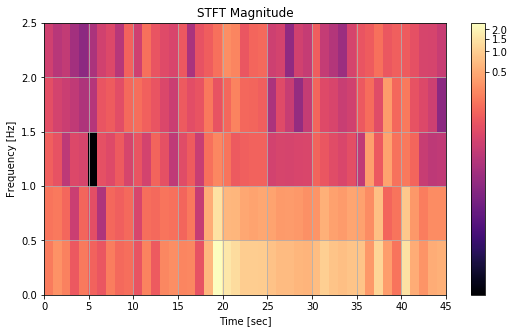

In [37]:
y = calcSTFT_norm(x,5,nperseg=10)


In [36]:
y = np.array(y)
y[2].shape

(3, 76)

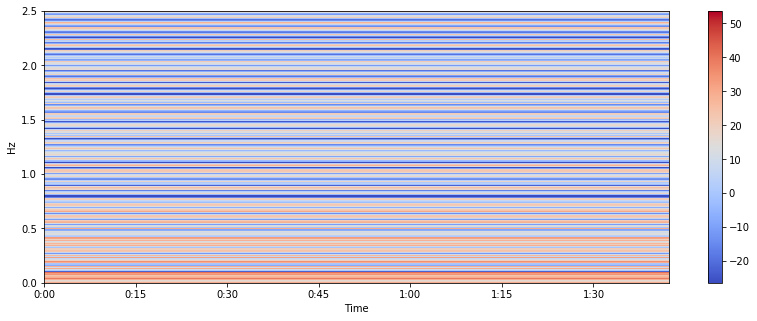

In [46]:
import librosa
import librosa.display
#display Spectrogram
d = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(d))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb,sr = 5, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

(20, 1)


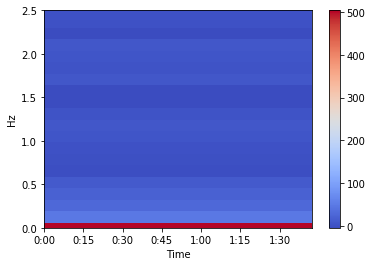

In [47]:
mfccs = librosa.feature.mfcc(x, sr=5)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=5, x_axis='time', y_axis='hz')
plt.colorbar()

In [51]:
plt.pcolormesh(t,f,Xdb)

NameError: name 'f' is not defined

In [40]:
f,t,Zxx = signal.stft(x,5,nperseg=10)

In [43]:
abs(Zxx).shape

(6, 46)

In [45]:
Zxx[0,0]

(0.18830579161680117+0j)